In [102]:
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import upsetplot as up
import ast



from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [103]:
main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_ids = load_tissue_ids(config)


In [104]:
gwas_meta = pd.read_csv(config['gwas_meta'], sep='\t', header=0)
gwas_ids = gwas_meta['Tag']

## load in the completed cluster gwas colocs

In [105]:

# Function to recursively get list of files ending with .qtl_gwas.txt
# this should later be updated to exclude the emp files

def get_files(directory):
    file_list = []
    for root, directories, files in os.walk(directory):
        for file in files:
            if file.endswith("susie_FALSE.gwas_coloc.txt"):
                file_list.append(os.path.join(root, file))
    return file_list

# Get the list of files
coloc_file_list = get_files(config['coloc_output_dir'])
len(coloc_file_list)

49

In [108]:

# Load each file into a DataFrame and concatenate them
cluster_colocs = []
for cluster_file in tqdm(coloc_file_list):
    cluster_coloc = pd.read_csv(cluster_file, sep='\t')  # Assuming tab-separated file
    tissue_id = cluster_file.split('/')[3]
    cluster_coloc['tissue_id'] = tissue_id
    cluster_colocs.append(cluster_coloc)

# Concatenate all DataFrames into a single DataFrame
gwas_coloc = pd.concat(cluster_colocs, ignore_index=True)
gwas_coloc['cluster_id'] = np.where(gwas_coloc['qtl_id'].str.contains('_e'), gwas_coloc['qtl_id'].str.split('_e').str[0], gwas_coloc['qtl_id'].str.split('_pc').str[0])
# Print the combined DataFrame
gwas_coloc

  0%|          | 0/49 [00:00<?, ?it/s]

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,gwas_id,qtl_id,tissue_id,cluster_id
0,4807,1.053141e-16,1.095288e-10,9.615183e-07,0.999999,4.050302e-08,BCAC_ER_positive_BreastCancer_EUR,ENSG00000117222.13_ENSG00000174529.7_e_ENSG000...,Muscle_Skeletal,ENSG00000117222.13_ENSG00000174529.7
1,4807,6.859456e-13,7.133977e-07,9.615176e-07,0.999998,4.086441e-08,BCAC_ER_positive_BreastCancer_EUR,ENSG00000117222.13_ENSG00000174529.7_pc1,Muscle_Skeletal,ENSG00000117222.13_ENSG00000174529.7
2,4807,2.694343e-07,2.802172e-01,6.916314e-07,0.719311,4.711937e-04,BCAC_ER_positive_BreastCancer_EUR,ENSG00000117222.13_ENSG00000174529.7_pc2,Muscle_Skeletal,ENSG00000117222.13_ENSG00000174529.7
3,5047,2.444624e-25,3.594430e-05,6.800900e-21,0.999964,6.397565e-08,EAGLE_Eczema,ENSG00000143520.6_ENSG00000143536.7_ENSG000001...,Muscle_Skeletal,ENSG00000143520.6_ENSG00000143536.7_ENSG000001...
4,5047,4.439841e-24,6.528078e-04,6.796597e-21,0.999331,1.603225e-05,EAGLE_Eczema,ENSG00000143520.6_ENSG00000143536.7_ENSG000001...,Muscle_Skeletal,ENSG00000143520.6_ENSG00000143536.7_ENSG000001...
...,...,...,...,...,...,...,...,...,...,...
1499,1863,2.376714e-01,5.590122e-03,7.391769e-01,0.017386,1.760858e-04,UKB_20002_1289_self_reported_schizophrenia,ENSG00000167371.17_ENSG00000280789.1_e_ENSG000...,Thyroid,ENSG00000167371.17_ENSG00000280789.1
1500,1831,3.788154e-29,8.912496e-31,9.769474e-01,0.022985,6.770359e-05,UKB_20002_1289_self_reported_schizophrenia,ENSG00000090238.11_ENSG00000149922.10_e_ENSG00...,Thyroid,ENSG00000090238.11_ENSG00000149922.10
1501,1831,1.946233e-74,4.578958e-76,9.763283e-01,0.022970,7.020811e-04,UKB_20002_1289_self_reported_schizophrenia,ENSG00000090238.11_ENSG00000149922.10_e_ENSG00...,Thyroid,ENSG00000090238.11_ENSG00000149922.10
1502,1831,1.152347e-78,2.711159e-80,9.765790e-01,0.022976,4.451606e-04,UKB_20002_1289_self_reported_schizophrenia,ENSG00000090238.11_ENSG00000149922.10_pc1,Thyroid,ENSG00000090238.11_ENSG00000149922.10


In [37]:
#gwas_coloc = gwas_coloc[(gwas_coloc['hit1'].isna())]

In [109]:
gwas_coloc_melted  = gwas_coloc.melt(id_vars=['tissue_id', 'gwas_id', 'qtl_id'], value_name='prob', var_name='prob_type', value_vars=[f'PP.H{i}.abf' for i in range(5)])

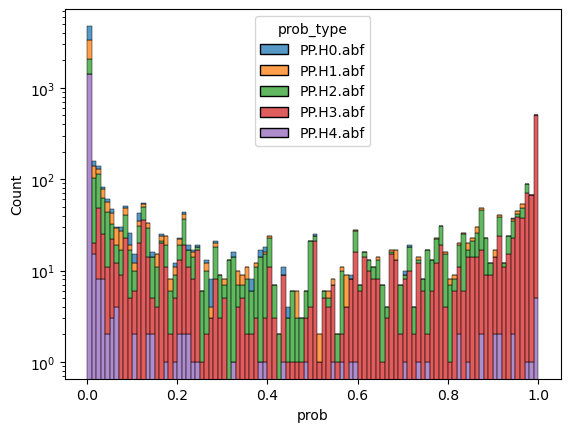

In [112]:
ax = sns.histplot(gwas_coloc_melted, x='prob', hue='prob_type', bins=100, multiple='stack')
ax.set_yscale('log')

In [115]:
# plot of which hypothesis is most probable for each row
gwas_coloc['highest_prob'] = gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']].idxmax(axis=1)


<AxesSubplot: xlabel='count', ylabel='highest_prob'>

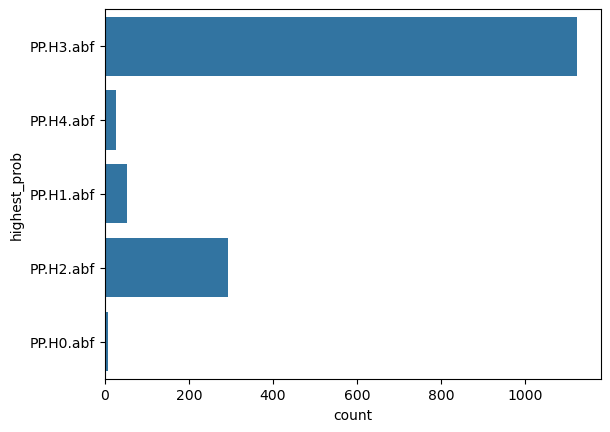

In [118]:
sns.countplot(gwas_coloc['highest_prob'])

In [111]:
gwas_coloc[gwas_coloc['PP.H4.abf'] > .7]

,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,gwas_id,qtl_id,tissue_id,cluster_id
27,4316,5.824749e-11,1.505164e-06,3.287483e-06,0.084035,0.915960,EAGLE_Eczema,ENSG00000115602.16_ENSG00000115604.10_e_ENSG00...,Muscle_Skeletal,ENSG00000115602.16_ENSG00000115604.10
28,4316,2.160792e-08,5.583667e-04,3.365306e-06,0.086049,0.913389,EAGLE_Eczema,ENSG00000115602.16_ENSG00000115604.10_pc1,Muscle_Skeletal,ENSG00000115602.16_ENSG00000115604.10
238,2589,1.051995e-19,1.298757e-18,1.864899e-02,0.229482,0.751869,pgc.scz2,ENSG00000054116.11_ENSG00000116871.15_e_ENSG00...,Thyroid,ENSG00000054116.11_ENSG00000116871.15
239,2589,3.014462e-11,3.721553e-10,1.993824e-02,0.245416,0.734646,pgc.scz2,ENSG00000054116.11_ENSG00000116871.15_pc1,Thyroid,ENSG00000054116.11_ENSG00000116871.15
240,2589,3.206609e-04,3.958771e-03,1.101750e-02,0.135169,0.849534,pgc.scz2,ENSG00000054116.11_ENSG00000116871.15_pc2,Thyroid,ENSG00000054116.11_ENSG00000116871.15
363,4408,2.973602e-59,2.741592e-58,1.757987e-02,0.161261,0.821159,CARDIoGRAM_C4D_CAD_ADDITIVE,ENSG00000183386.9_ENSG00000183431.11_e_ENSG000...,Thyroid,ENSG00000183386.9_ENSG00000183431.11
364,4408,4.108262e-44,3.787722e-43,9.299574e-03,0.084834,0.905866,CARDIoGRAM_C4D_CAD_ADDITIVE,ENSG00000183386.9_ENSG00000183431.11_e_ENSG000...,Thyroid,ENSG00000183386.9_ENSG00000183431.11
365,4408,1.063246e-83,9.802879e-83,5.935836e-03,0.053787,0.940277,CARDIoGRAM_C4D_CAD_ADDITIVE,ENSG00000183386.9_ENSG00000183431.11_pc1,Thyroid,ENSG00000183386.9_ENSG00000183431.11
505,3347,2.094724e-27,7.613812e-26,3.254958e-03,0.117431,0.879315,UKB_1807_Fathers_age_at_death,ENSG00000109182.11_ENSG00000109184.14_pc1,Thyroid,ENSG00000109182.11_ENSG00000109184.14
666,5300,2.110790e-133,1.110702e-129,2.472140e-05,0.129214,0.870761,BCAC_Overall_BreastCancer_EUR,ENSG00000152348.15_ENSG00000186468.12_ENSG0000...,Thyroid,ENSG00000152348.15_ENSG00000186468.12_ENSG0000...


first look just at the number of hits, not trying to overlap pc and eqtls 

In [119]:
# make ids for each credible set in the qtl and gwas
# if susie
#gwas_coloc['gwas_cs_id'] = gwas_coloc['gwas_id'] + '_' + gwas_coloc['hit1']
#gwas_coloc['qtl_cs_id'] = gwas_coloc['qtl_id'] + '_' + gwas_coloc['hit2'].astype(str)

# otherwise
gwas_coloc['gwas_cs_id'] = gwas_coloc['gwas_id'] + '_' + gwas_coloc['cluster_id']
gwas_coloc['qtl_cs_id'] = gwas_coloc['qtl_id']+ '_' + gwas_coloc['cluster_id']


In [120]:
# count number of e and pc hits
gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > .75]
print('number pcqtls total (could overlap): {}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'))))
print('number eqtls total (could overlap):{}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_e'))))

number pcqtls total (could overlap): 8
number eqtls total (could overlap):11


/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/2015912640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_coloc_hits['type'] = np.where(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'), 'pcqtl', 'eqtl')


<AxesSubplot: xlabel='Count', ylabel='tissue_id'>

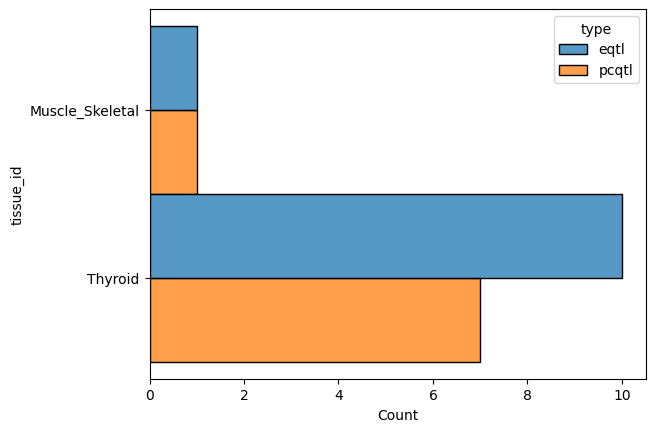

In [121]:
# raw counts (could overlap)
gwas_coloc_hits['type'] = np.where(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'), 'pcqtl', 'eqtl')
sns.histplot(gwas_coloc_hits, hue='type', y='tissue_id', multiple='dodge')

In [122]:
gwas_coloc_counts = gwas_coloc_hits.groupby('tissue_id').agg({'qtl_cs_id':'unique'})
gwas_coloc_counts['num_e'] = gwas_coloc_counts['qtl_cs_id'].astype(str).str.count('_e')
gwas_coloc_counts['num_pc'] = gwas_coloc_counts['qtl_cs_id'].astype(str).str.count('_pc')
gwas_coloc_counts['num_colocs'] = gwas_coloc_counts['num_e'] + gwas_coloc_counts['num_pc']

gwas_coloc_counts

,qtl_cs_id,num_e,num_pc,num_colocs
tissue_id,,,,
Muscle_Skeletal,[ENSG00000115602.16_ENSG00000115604.10_e_ENSG0...,1,1,2
Thyroid,[ENSG00000054116.11_ENSG00000116871.15_e_ENSG0...,8,6,14


/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/1038350952.py:8: UserWarning: The palette list has more values (13) than needed (2), which may not be intended.
  ax = sns.barplot(gwas_coloc_counts, x='num_colocs', hue='tissue_id', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)
/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/1038350952.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


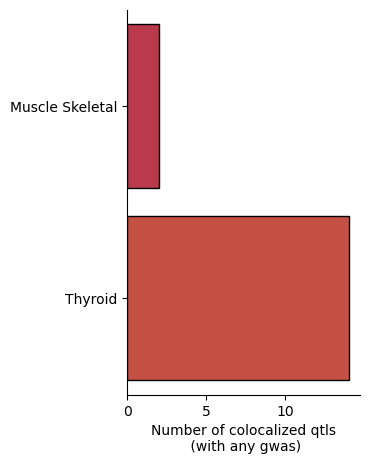

In [123]:
# make a simple plot with total colocs in each tissue (the signals could overlap)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


# plot showing number of clusters in each tissue

fig, ax = plt.subplots(figsize=(3,5))
ax = sns.barplot(gwas_coloc_counts, x='num_colocs', hue='tissue_id', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of colocalized qtls\n (with any gwas)')
ax.set_ylabel('')

plt.show()

<AxesSubplot: xlabel='num_gwas', ylabel='Count'>

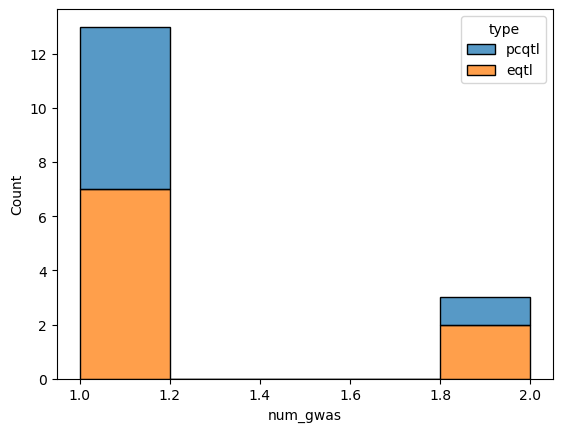

In [124]:
# number of gwas hits per qtl
gwas_grouped_colocs = gwas_coloc_hits.groupby('qtl_cs_id').agg({'gwas_cs_id':'unique', 
                                                             'type':'first'})
gwas_grouped_colocs['num_gwas'] = gwas_grouped_colocs['gwas_cs_id'].apply(len)
sns.histplot(gwas_grouped_colocs, x='num_gwas', hue='type', multiple='stack')

if there are a lot of high numbers in the above plot, I may need to rethink not combining over gwas loci in some way below. currently if a an eqtl loci colocs with 3 gwas loci, that counts for 3 colocs in the below plots?

now combine around gwas signals - does each one colocalize to a pcqtl, an eqtl, or multiple pcqtls?

In [125]:
# group by qtl signal
gwas_coloc_overlap = gwas_coloc_hits.groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique'})

# count things
gwas_coloc_overlap['num_hits'] = gwas_coloc_overlap['qtl_cs_id'].apply(len)
gwas_coloc_overlap['num_eqtl'] = gwas_coloc_overlap['qtl_cs_id'].astype(str).str.count('_e')
gwas_coloc_overlap['num_pcqtl'] = gwas_coloc_overlap['qtl_cs_id'].astype(str).str.count('_pc')
gwas_coloc_overlap['hit_type'] = np.where(gwas_coloc_overlap['num_eqtl']>0, np.where(gwas_coloc_overlap['num_pcqtl']>0, 'both', 'eqtl_only'), 
                                          np.where(gwas_coloc_overlap['num_pcqtl']>0, 'pcqtl_only', 'neither??'))

/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/3260416558.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


Text(0.5, 0, 'Number of colocalized QTLs (each gwas counts seperately)')

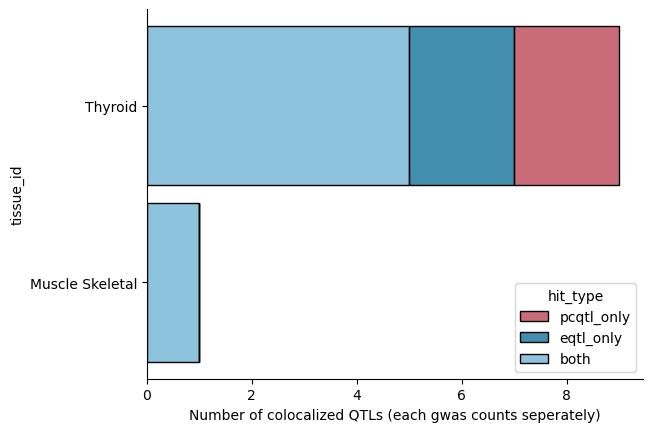

In [126]:
# histogram with gtle type

ax = sns.histplot(gwas_coloc_overlap, y='tissue_id', hue='hit_type', multiple='stack', 
             hue_order=['pcqtl_only','eqtl_only', 'both'], 
             palette=('#B83A4B', '#016895', '#67AFD2'), 
             shrink=.9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of colocalized QTLs (each gwas counts seperately)')


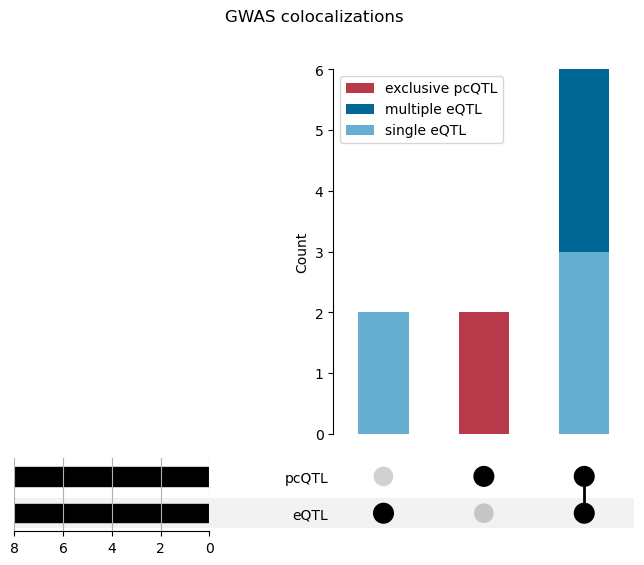

In [127]:
# make indicator columns 
gwas_coloc_overlap['pcQTL'] = gwas_coloc_overlap['num_pcqtl'] > 0
gwas_coloc_overlap['eQTL'] = gwas_coloc_overlap['num_eqtl'] > 0

# multiple egenes
gwas_coloc_overlap['multiple_e_shared'] = gwas_coloc_overlap['num_eqtl']>1  

upset_to_plot = gwas_coloc_overlap.set_index('eQTL').set_index('pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations')
plt.show()

now make it  so that each gwas doesn't count seperately

In [128]:
# something about tissue sharing??
gwas_coloc_hits['gwas_tissue_cs_id'] = gwas_coloc_hits['gwas_cs_id'] + '_' + gwas_coloc_hits['tissue_id']
gwas_coloc_hits['qtl_tissue_cs_id'] = gwas_coloc_hits['qtl_cs_id'] + '_' + gwas_coloc_hits['tissue_id']

qtl_grouped_colocs = gwas_coloc_hits.groupby('qtl_tissue_cs_id').agg({'gwas_tissue_cs_id':'unique'})
gwas_grouped_colocs = gwas_coloc_hits.groupby('gwas_tissue_cs_id').agg({'qtl_tissue_cs_id':'unique'})

/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/1952816446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_coloc_hits['gwas_tissue_cs_id'] = gwas_coloc_hits['gwas_cs_id'] + '_' + gwas_coloc_hits['tissue_id']
/local/scratch/klawren/slrmtmp.45342476/ipykernel_42135/1952816446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_coloc_hits['qtl_tissue_cs_id'] = gwas_coloc_hits['qtl_cs_id'] + '_' + gwas_coloc_hits['tissue_id']


In [129]:
qtl_sets = []
gwas_sets = []
for idx, row in gwas_grouped_colocs.iloc[:30].iterrows():
    qtl_set = set(row['qtl_tissue_cs_id'].astype(list))
    new_qtls = 1
    new_gwas = 1
    gwas_set = set([idx])
    # expand the set to all overlapping qtls and gwas
    while ((new_qtls > 0) | (new_gwas > 1)):
        gwas_set_old = gwas_set
        qtl_set_old = qtl_set
        for gwas_cs_id in gwas_set:
            qtl_set = set(np.append(list(qtl_set), gwas_grouped_colocs.loc[gwas_cs_id,'qtl_tissue_cs_id']))
        new_qtls = len(qtl_set) - len(qtl_set_old)
        for qtl_cs_id in qtl_set:
            gwas_set = set(np.append(list(gwas_set), qtl_grouped_colocs.loc[qtl_cs_id,'gwas_tissue_cs_id']))
        new_gwas = len(gwas_set) - len(gwas_set_old)

    qtl_sets.append(set(qtl_set))
    gwas_sets.append(set(gwas_set))


coloc_sets = pd.DataFrame({'gwas_sets':gwas_sets, 
              'qtl_sets':qtl_sets})

coloc_sets['sorted_gwas_sets'] = coloc_sets['gwas_sets'].apply(lambda x: sorted(list(x))).astype(str)
coloc_sets['sorted_qtl_sets'] = coloc_sets['qtl_sets'].apply(lambda x: sorted(list(x))).astype(str)

coloc_sets = coloc_sets[['sorted_gwas_sets', 'sorted_qtl_sets']].drop_duplicates()

# these should all be the same
print(len(coloc_sets))
print(len(coloc_sets['sorted_gwas_sets'].unique()))
print(len(coloc_sets['sorted_qtl_sets'].unique()))

coloc_sets['num_eqtl'] = coloc_sets['sorted_qtl_sets'].str.count('_e')
coloc_sets['num_pcqtl'] = coloc_sets['sorted_qtl_sets'].str.count('_pc')


9
9
9


In [130]:
def get_tissue_ids(signal_set):
    tissue_ids = []
    for signal_id in ast.literal_eval(signal_set):
        tissue_ids.append(signal_id.split('_')[-1])
    return list(set(tissue_ids))

def get_pheno_ids(signal_set):
    tissue_ids = []
    for signal_id in ast.literal_eval(signal_set):
        tissue_ids.append(signal_id.split('_')[-1])
    return list(set(tissue_ids))

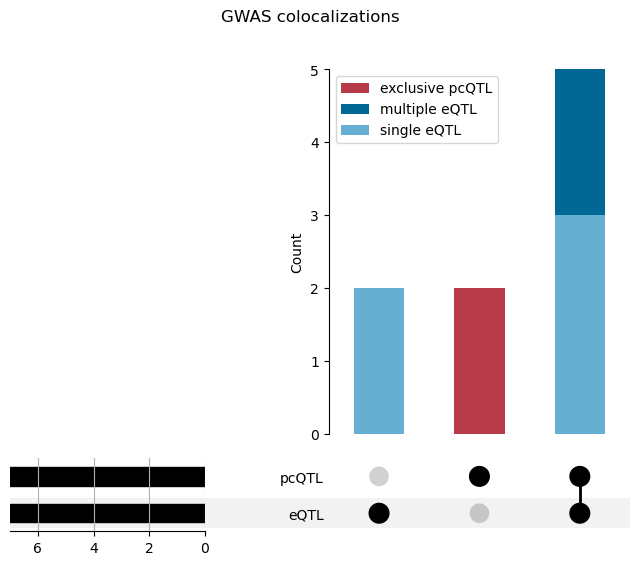

In [131]:
# make indicator columns 
coloc_sets['pcQTL'] = coloc_sets['num_pcqtl'] > 0
coloc_sets['eQTL'] = coloc_sets['num_eqtl'] > 0

# multiple egenes
coloc_sets['multiple_e_shared'] = coloc_sets['num_eqtl']>1  

upset_to_plot = coloc_sets.set_index('eQTL').set_index('pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations')
plt.show()

In [132]:
coloc_sets['qtl_tissues'] = coloc_sets['sorted_qtl_sets'].apply(get_tissue_ids)
coloc_sets['qtl_clusters'] = coloc_sets['sorted_qtl_sets'].apply(get_pheno_ids)
coloc_sets['num_clusters'] = coloc_sets['qtl_tissues'].apply(len)
coloc_sets['num_qtl_tissues'] = coloc_sets['qtl_clusters'].apply(len)


coloc_sets['gwas_tissues'] = coloc_sets['sorted_gwas_sets'].apply(get_tissue_ids)
coloc_sets['gwas_types'] = coloc_sets['sorted_gwas_sets'].apply(get_pheno_ids)
coloc_sets['num_gwas_tissues'] = coloc_sets['gwas_tissues'].apply(len)
coloc_sets['num_gwas_types'] = coloc_sets['gwas_types'].apply(len)

coloc_sets['type'] = np.where(coloc_sets['num_pcqtl']>0, np.where(coloc_sets['num_eqtl']>0, 'both', 'pcqtl_only'), 'eqtl_only')

<AxesSubplot: xlabel='num_gwas_tissues', ylabel='Count'>

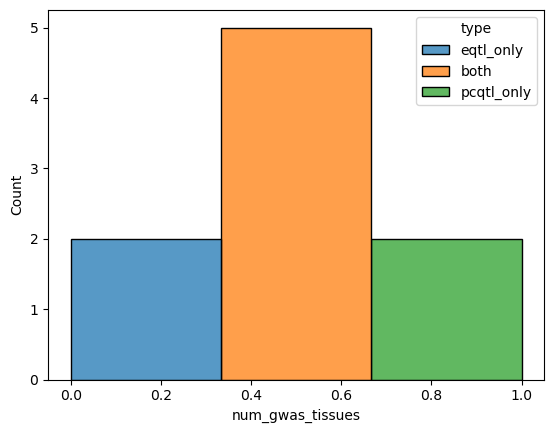

In [133]:
# number of tissues vs signal type
sns.histplot(coloc_sets, x='num_gwas_tissues', hue='type', multiple='dodge', bins=range(0, max(coloc_sets['num_gwas_tissues'])+1))


<AxesSubplot: xlabel='num_gwas_types', ylabel='Count'>

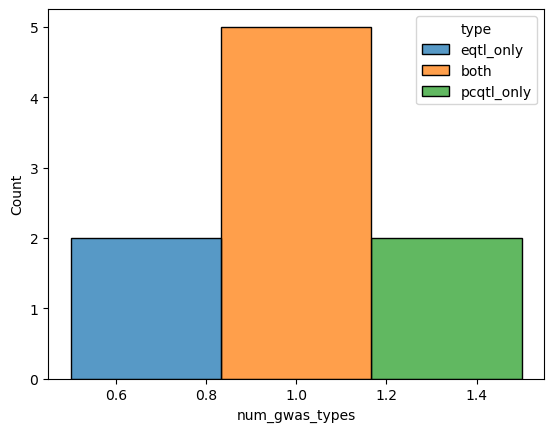

In [134]:
sns.histplot(coloc_sets, x='num_gwas_types', hue='type', multiple='dodge')

<AxesSubplot: xlabel='num_qtl_tissues', ylabel='Count'>

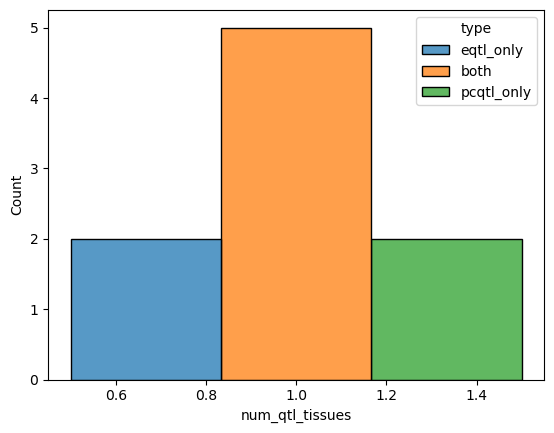

In [135]:
sns.histplot(coloc_sets, x='num_qtl_tissues', hue='type', multiple='dodge')

<AxesSubplot: xlabel='num_clusters', ylabel='Count'>

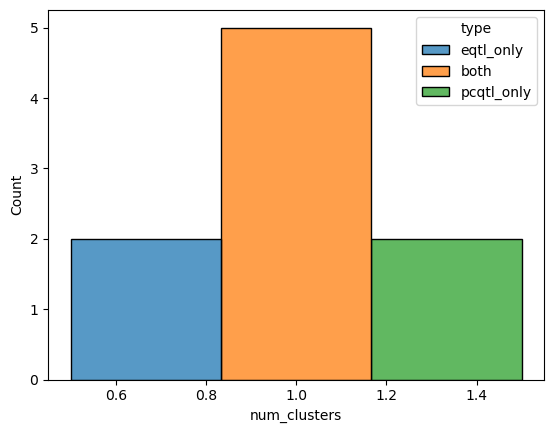

In [136]:
# ideally this should be all 1
sns.histplot(coloc_sets, x='num_clusters', hue='type', multiple='dodge')